In [1]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils
import modules


from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config
import torch.nn.functional as F


from torch.distributions import Normal

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label


In [59]:
loadedZeros = torch.load('../data/zeroImages.pt')
loadedOnes = torch.load('../data/oneImages.pt')

dataset01 = torch.cat((loadedZeros, loadedOnes), dim=0)
labels01 = torch.zeros(len(loadedZeros)+len(loadedOnes))
labels01[len(loadedOnes):] = 1

torch.manual_seed(52)
indices = torch.randperm(dataset01.size(0))

data_array = dataset01[indices]
label_array = labels01[indices].long()


#    Create an instance of your custom dataset
dataset = CustomDataset(data_array, label_array)

In [60]:
#load the model (code from load_checkpoint function in trainer.py):

config, unparsed = get_config()


filename = "../ckpt/ram_15_1x1_1_model_best.pth.tar"

ckpt = torch.load(filename) #model

# build RAM model
config, unparsed = get_config()

ram0 = model.RecurrentAttention(
    1,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)

ram0
ram0.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [61]:
#torch.manual_seed(config.random_seed+10)

In [62]:
print(" Model data:\n patch size: " + str(config.patch_size) + 
    "\n num_patches: " + str(config.num_patches)+
    "\n glimpse_scale: " + str(config.glimpse_scale)+
    "\n num_channels: " + str(1)+
    "\n loc_hidden: " + str(config.loc_hidden)+
    "\n glimpse_hidden: " + str(config.glimpse_hidden)+
    "\n std: " + str(config.std)+
    "\n hidden_size: " + str(config.hidden_size)+
    "\n num_classes: " + str(10))

 Model data:
 patch size: 1
 num_patches: 1
 glimpse_scale: 1
 num_channels: 1
 loc_hidden: 128
 glimpse_hidden: 128
 std: 0.05
 hidden_size: 256
 num_classes: 10


In [63]:
ram0

RecurrentAttention(
  (sensor): GlimpseNetwork(
    (fc1): Linear(in_features=1, out_features=128, bias=True)
    (fc2): Linear(in_features=2, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=128, out_features=256, bias=True)
  )
  (rnn): CoreNetwork(
    (i2h): Linear(in_features=256, out_features=256, bias=True)
    (h2h): Linear(in_features=256, out_features=256, bias=True)
  )
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=4, bias=True)
  )
  (classifier): ActionNetwork(
    (fc): Linear(in_features=256, out_features=10, bias=True)
  )
  (baseliner): BaselineNetwork(
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [64]:
def reset():
    h_t = torch.zeros(
        1,
        config.hidden_size,
        dtype=torch.float,
        requires_grad=True,
    )
    # l_t = torch.FloatTensor(
    #    self.batch_size, 2).uniform_(-1, 1).to(self.device)
    # print(l_t)
    l_t = torch.zeros(1, 2)
    
    l_t.requires_grad = True

    return h_t, l_t

reset()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [65]:
l_t = torch.tensor([[-0.8,-0.8]])
l_t


tensor([[-0.8000, -0.8000]])

In [66]:
l_t = torch.zeros(1, 2)
l_t

tensor([[0., 0.]])

In [67]:
dataset[31][0].shape

torch.Size([1, 28, 28])

In [98]:
mnistImage, label = dataset[149]
mnistImage = mnistImage.unsqueeze(1)
#do 5 glimpses
h_t, l_t = reset()

loc_list = []
for t in range(15):
    # forward pass through model
    h_t, l_t, b_t, p = ram0(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram0(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))


Prediction: 1, actual: tensor(1)


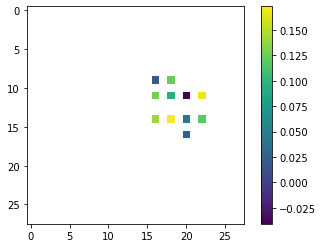

In [99]:
num_patches = config.num_patches
scale = config.glimpse_scale
patch_size = config.patch_size

glimpses = []
for loc in loc_list:
    ret = Retina(g=1, k=num_patches, s=scale)
    glimpse = ret.foveate(mnistImage, loc).data.numpy()
    glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])
    glimpses.append(glimpse)

H = len(mnistImage[0][0])
showGlimpses = np.ones((H, H))*np.nan

# Update the positions with the glimpse values
for i in range(len(glimpses)):
    indices = Retina.denormalize(_, len(mnistImage[0][0]), loc_list[i])
    x, y = indices.tolist()[0]
    showGlimpses[y, x] = glimpses[i]

# Plot the image using imshow
plt.imshow(showGlimpses, cmap='viridis')
plt.colorbar()
plt.show()

In [102]:
showGlimpses[11]

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,  0.12951469,         nan,  0.09442985,         nan,
       -0.0409995 ,         nan,  0.16882038,         nan,         nan,
               nan,         nan,         nan])

In [103]:
mnistImage[0,0, 11]

tensor([ 0.1292,  0.1682,  0.0762,  0.0605,  0.1914,  0.1467,  0.0015,  0.0924,
        -0.0138,  0.0017,  0.0839,  0.1783,  0.0506,  0.0740,  0.0851,  0.2024,
         0.1295, -0.0572,  0.0944,  0.1765, -0.0410,  0.1335,  0.1688,  0.1603,
         0.1806,  0.0052,  0.1399,  0.1647])

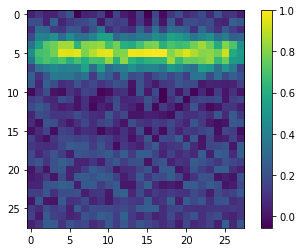

In [89]:
plt.imshow(mnistImage[0,0])
plt.colorbar()

# Analyzing LocationNetwork, change it to generate a number between 0-3, corresponding to direction

In [15]:
import modules

loc_net = modules.LocationNetwork(256, 2, 0.11)
log_pi, l_t = loc_net(h_t)
print(log_pi)
print(l_t)

tensor(-1.2021, grad_fn=<SqueezeBackward0>)
tensor([[0.1500, 0.0000]])


In [16]:
directions = torch.tensor([
    [1,0],
    [-1,0],
    [0,1],
    [0,-1]
])
mu = torch.tensor([[0.3027, 0.4452, 0.3499, 0.4361],
        [0.3773, 0.4617, 10.4198, 0.3919],
        [0.4046, 0.4530, 0.4341, 0.4491]])
index = torch.multinomial(mu, num_samples=1)
log_prob = torch.log(torch.gather(mu, 1, index))

print(index)
print(directions[index[:,0]])
print(log_prob.shape)


tensor([[3],
        [2],
        [2]])
tensor([[ 0, -1],
        [ 0,  1],
        [ 0,  1]])
torch.Size([3, 1])


In [17]:
mu = torch.tensor([0.1, 10.5, 3])
index = torch.multinomial(mu, num_samples=1)
index

tensor([1])

# Make intensity function at location

In [18]:
#testing denormalize function

"""Convert coordinates in the range [-1, 1] to
        coordinates in the range [0, T] where `T` is
        the size of the image.
        
        return (0.5 * ((coords + 1.0) * T)).long()
"""
H1 = 15
loc1 = torch.tensor([0.1, -0.09])
Retina.denormalize(_, H1, loc1)

tensor([8, 6])

In [19]:
torch.tensor(4.3).long()

tensor(4)

In [20]:
def intensity(loc, img):
    """
    loc is tensor([y, x]), 
    img is tensor with shape: (1,H,W), generally H=W
    returns intensity of 3x3 square centered about loc
    """
    totalCharge = 0
    nRows, nColumns = img.shape
    xLoc = loc[1].item()
    yLoc = loc[0].item()

    boostedImg = torch.sub(img, torch.min(img))

    for yi in range(nRows):
        for xi in range(nColumns):
            r2 = (xLoc - xi) ** 2 + (yLoc - yi) ** 2
            if (r2 != 0):
                pointCharge = boostedImg[yi, xi]/r2
                totalCharge += pointCharge

    tanhTotal = torch.tanh(totalCharge/(nRows))
    return tanhTotal.item()


0.1973753273487091


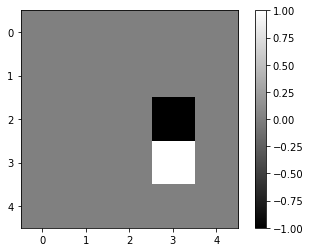

In [21]:
testImg1 = torch.zeros([5,5])
#testImg1[0,0] = 1
testImg1[3,3] = 1
#testImg1[4,3] = 1

testLoc1 = torch.tensor([2,3])
print(intensity(testLoc1, testImg1))

outImg = testImg1 + 0
outImg[testLoc1[0].item(), testLoc1[1].item()] = -1
plt.imshow(outImg, cmap="gray")
plt.colorbar()

In [22]:
testImg1[testLoc1[0]-1: testLoc1[0]+2, testLoc1[1]-1: testLoc1[1]+2]


tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]])

0.009842513129115105


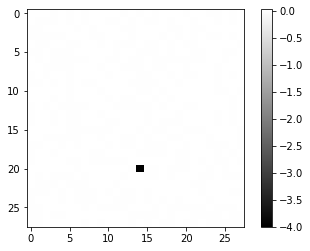

In [23]:
mnistImage, label = dataset[89]
mnistImage = mnistImage.unsqueeze(1)

#mnistImage = torch.ones_like(mnistImage)

testLoc2 = torch.tensor([20, 14])

print(intensity(testLoc2, mnistImage[0][0]))

outImg = mnistImage[0][0] + 0
outImg[testLoc2[0].item(), testLoc2[1].item()] = -4

plt.imshow(outImg, cmap="gray")
plt.colorbar()

In [24]:
torch.min(mnistImage)

tensor(5.5945e-05)

In [25]:
torch.max(dataset[53][0])

tensor(1.)

In [26]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])


index = 141
minMNIST = torch.min(dataset[index][0]).item()
maxMNIST = torch.max(dataset[index][0]).item()


print(minMNIST)
print(maxMNIST)

-0.05567198619246483
1.0


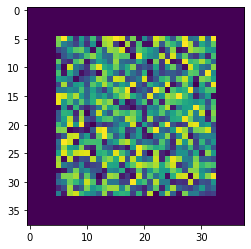

In [27]:
#mnistImage, label = dataset[89]

#mnistImage = mnistImage.unsqueeze(0)
mnistImage = F.pad(mnistImage, (5, 5, 5, 5), value=torch.min(mnistImage))
mnistImage.shape

plt.imshow(mnistImage[0,0])

In [28]:
random_tensor = torch.rand(10, 2)


In [29]:
print(random_tensor)
torch.max(random_tensor, 1)[1]

tensor([[0.4982, 0.5722],
        [0.5658, 0.7411],
        [0.3666, 0.7527],
        [0.5486, 0.2926],
        [0.1450, 0.4141],
        [0.1558, 0.6521],
        [0.7694, 0.8216],
        [0.8152, 0.4975],
        [0.7629, 0.4276],
        [0.2531, 0.5925]])


tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [30]:
torch.max(random_tensor, 1)

torch.return_types.max(
values=tensor([0.5722, 0.7411, 0.7527, 0.5486, 0.4141, 0.6521, 0.8216, 0.8152, 0.7629,
        0.5925]),
indices=tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1]))

TMI

# Working on generating dataset

In [31]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", download = False, transform=trans)
mnistImage, label = dataset[211]
mnistImage = mnistImage.unsqueeze(1)

In [32]:
len(dataset)

60000

In [33]:
type(dataset)

torchvision.datasets.mnist.MNIST

In [34]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [35]:
zeroImages = []
oneImages = []

for i in range(1000):
    if(dataset[i][1] == 0):
        zeroImages.append(dataset[i][0])
    if(dataset[i][1] == 1):
        oneImages.append(dataset[i][0])
        
zeroImages = torch.stack(zeroImages)
oneImages = torch.stack(oneImages)

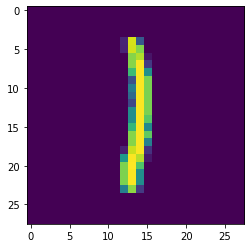

In [36]:
plt.imshow(oneImages[10, 0])

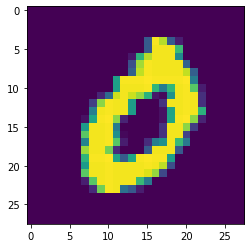

In [37]:
plt.imshow(zeroImages[3, 0])

In [38]:
zeroImages.shape

torch.Size([97, 1, 28, 28])

In [39]:
print(zeroImages.dtype)

torch.float32


In [40]:
"""
# Save the tensor to a file
torch.save(zeroImages, '../data/zeroImages.pt')
torch.save(oneImages, '../data/oneImages.pt')


# Load the tensor from the file
loadedZeros = torch.load('../data/zeroImages.pt')

"""

"\n# Save the tensor to a file\ntorch.save(zeroImages, '../data/zeroImages.pt')\ntorch.save(oneImages, '../data/oneImages.pt')\n\n\n# Load the tensor from the file\nloadedZeros = torch.load('../data/zeroImages.pt')\n\n"

In [41]:
print(len(oneImages))

116


In [42]:
a1 = torch.tensor([1,2,3,4,5])
b1 = torch.tensor([6,7,8,9,10])


In [43]:
dataset01 = torch.cat((zeroImages, oneImages), dim=0)
labels01 = torch.zeros(len(zeroImages)+len(oneImages))
labels01[len(oneImages):] = 1

In [44]:
dataset01.size(0)

213

In [45]:
torch.manual_seed(52)
indices = torch.randperm(dataset01.size(0))

In [46]:
len(dataset01)

213

In [47]:
# Assuming you have your data and labels as NumPy arrays
data_array = dataset01[indices]  # Shape: (10000, 28, 28)
label_array = labels01[indices] # Shape: (10000,)

# Create an instance of your custom dataset
dataset = CustomDataset(data_array, label_array)

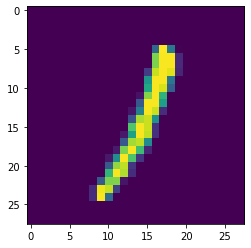

In [48]:
plt.imshow(dataset[39][0][0])

In [49]:
dataset01.shape

torch.Size([213, 1, 28, 28])

In [50]:
#try with model:

mnistImage, label = dataset[211]
mnistImage = mnistImage.unsqueeze(1)

#do 5 glimpses
h_t, l_t = reset()

loc_list = []
for t in range(15):
    # forward pass through model
    h_t, l_t, b_t, p = ram0(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram0(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))


Prediction: 1, actual: tensor(0.)


In [51]:
valid_size=0.1
shuffle=True
random_seed = 157
batch_size=32
num_workers = 4
pin_memory=False
dataset = dataset01
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
